# Python script for reading CALIPSO data

This is for reading CALIPSO level 2 aerosol product with the following format:

CAL_LID_L2_05kmAPro-Prov-V3-01

Used functions in ploting:

1. Aerosol type (2-d figure): plt.pcolor

2. Distance to ground station: plt.plot

Please run this script in jupyter notebook environment. Normally, this script (.ipynb) is not compatible with spyder. But if you need, just copy these codes to your .py script.

If you meet issues in using this script, feel free to contact: haoran.li@helsinki.fi

In [160]:
import numpy as np
import os
import subprocess
from pyhdf.SD import SD, SDC
import glob
from math import sin, cos, sqrt, atan2, radians

Path_folder = '/home/vagrant/calipso/'

Filename_list = glob.glob(Path_folder + '*.hdf')

Filename_list.sort()

filenum_start = 22
filenum_end = 23

distance_zeppelin = []

for indx_file in range(filenum_start,filenum_end):
    
    current_file = Filename_list[indx_file]
    file_loaded = SD(current_file, SDC.READ)
    
    # 0 day, 1 night
    day_night = file_loaded.select('Day_Night_Flag')
    
    # Latitude, Longitude, time   
    Latitude_raw = file_loaded.select('Latitude')
    Longitude_raw = file_loaded.select('Longitude')
    Time_UTC_raw = file_loaded.select('Profile_UTC_Time')
    
    # Note: each profile corresponds to an array with 3 values in raw data
    # Derive the middle one
    
    Latitude =  Latitude_raw[:,1]
    Longitude = Longitude_raw[:,1] 
    Time_UTC = Time_UTC_raw[:,1]
      
    # Variables relating to data quality control (important when you do statistics)
    AVD = file_loaded.select('Atmospheric_Volume_Description')
    CAD = file_loaded.select('CAD_Score')
    EQC_532 = file_loaded.select('Extinction_QC_Flag_532')
    EXT_532 = file_loaded.select('Extinction_Coefficient_532')
    ALF = file_loaded.select('Aerosol_Layer_Fraction')
    CLF = file_loaded.select('Cloud_Layer_Fraction')
    COD_532 = file_loaded.select('Column_Optical_Depth_Cloud_532')
    
    
    back_scatt_532 = file_loaded.select('Total_Backscatter_Coefficient_532')
    depol_532 = file_loaded.select('Particulate_Depolarization_Ratio_Profile_532')
    
    # Altitude is stored in metadata, a different data format from variable.
    # It seems that we could only seek help from terminal command to get alt data...    
    FNULL = open(os.devnull, 'w')
    command = 'hdp dumpvd -d -n metadata -f Lidar_Data_Altitudes ' + current_file
    dump = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=FNULL).communicate()[0]
    alt = np.array(dump.split(), dtype='float32')   
    
    Aerosol_type = np.empty([len(Latitude),len(alt)]) * np.nan
    
    for indx_i in range( 0,len(Latitude) ):
        
        for indx_j in range( 0,len(AVD[0]) ):            

            # CALIPSO feature classification.
            # Read first 3 bits. (direction: from back to front) 101 is aerosol
            aerosol_flag = np.bitwise_and( AVD[indx_i,indx_j][0], 7)
            
            # Aerosol type classification.
            # 10-12 bits (direction: from back to front) flag aerosol type
            aerosol_type_bin = np.bitwise_and( AVD[indx_i,indx_j][0], np.power(2,9)+np.power(2,10)+np.power(2,11) ) \
            /float( np.power(2,9) )
            
            if aerosol_flag == 3 :
                Aerosol_type[indx_i,indx_j] = aerosol_type_bin              
                    
        
        # Caculate distance between sub-satellite point and ground station.
        # (78.92,11.85) is coordinate for Zeppelin Station
        
        # approximate radius of earth in km
        R = 6373.0

        lat1 = radians(Latitude[indx_i])
        lon1 = radians(Longitude[indx_i])
        lat2 = radians(78.92)
        lon2 = radians(11.85)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c

        distance_zeppelin.append(distance)      
            

# Plot figure for different aerosol types

1. Aerosol type (2-d figure): plt.pcolor

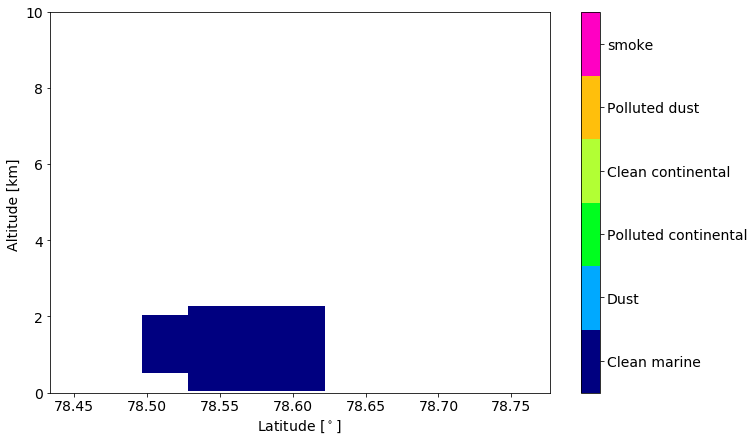

In [161]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig = plt.figure(figsize=[7*1.6,7])
ax=plt.subplot(111)

# Number of discrete colors in colorbar
bounds = np.array([1, 2, 3, 4, 5, 6, 7])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=200)

# Cmap color setting may not be so beatiful.....
colormap = plt.get_cmap('gist_ncar')

plt_inst = plt.pcolor( Latitude, alt, np.transpose(Aerosol_type),
                      norm = norm, cmap=colormap )

cb = plt.colorbar(mappable=plt_inst, ticks = bounds+0.5 )

cb.ax.set_yticklabels(['Clean marine','Dust',
                       'Polluted continental','Clean continental','Polluted dust','smoke','other'])

# Showing aerosol classification below 10 km
ax.set_ylim(0,10)

ax.set_xlabel('Latitude [$^\circ$] ')
ax.set_ylabel('Altitude [km] ')

# font size and color 
font = {'family' : 'sans-serif',
                    'weight' : 'light',
                    'size'   : 14}
plt.rc('font', **font) 

plt.show()

#fig.savefig('*.png')

# Plot figure for different aerosol types

2. Distance to ground station: plt.plot

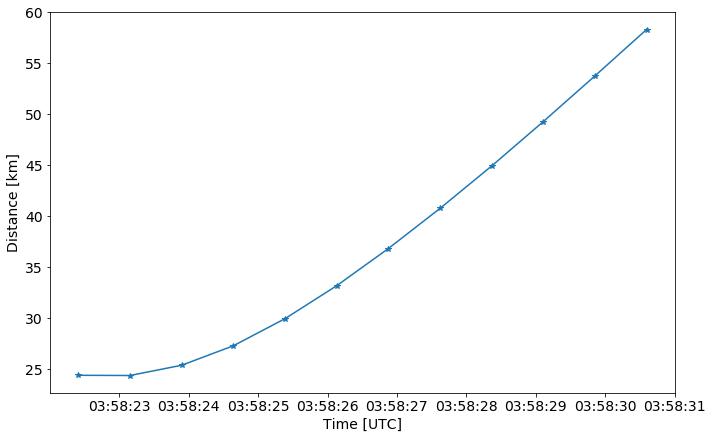

In [162]:
import matplotlib.pyplot as plt
import datetime

fig = plt.figure(figsize=[7*1.6,7])
ax=plt.subplot(111)

Time_UTC_int = ( Time_UTC+20000000 ).astype(int)


# Convert CALIPSO time into datetime format in Python

date_plot = []
for indx_i in range(0,len(Time_UTC_standard)):    
    
    delta_day = datetime.timedelta( days=Time_UTC[indx_i] - int(Time_UTC[indx_i]) )
    date_plot.append( datetime.datetime.strptime( str(Time_UTC_int[indx_i]),
                                                 "%Y%m%d" ) + delta_day )

plt.plot(date_plot,distance_zeppelin,'*-')

ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Distance [km]')

# font size and color 
font = {'family' : 'sans-serif',
                    'weight' : 'light',
                    'size'   : 14}
plt.rc('font', **font) 

# show figure
plt.show()
#fig.savefig('*.png')